In [1]:
# Importación de las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Cargamos los datos de entrenamiento y el maestro de productos
data = pd.read_csv('train.csv', delimiter='|')
product_data = pd.read_csv('RentabilidadProduct.csv', delimiter='|')



In [3]:
# Combinamos los datos de entrenamiento con los datos del producto
combined_data = pd.merge(data, product_data, on='product_id')

# Visualizamos las primeras filas de los datos combinados
combined_data.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,family_id,negocio_id,category_id,tier_id,utilidad_bruta_transf
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,0.005211,1427,20,173,2,-0.306416
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,0.062530,1427,20,173,2,-0.306416
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,0.062530,1427,20,173,2,-0.306416


In [4]:
combined_data.isnull().sum().sum()

0

In [5]:
combined_data.duplicated().sum()

0

In [6]:
# Convertimos 'customer_id' y 'product_id' a tipo categórico
combined_data['customer_id'] = combined_data['customer_id'].astype('category')
combined_data['product_id'] = combined_data['product_id'].astype('category')
combined_data['type_id'] = combined_data['type_id'].astype('category')
combined_data['business_id'] = combined_data['business_id'].astype('category')
combined_data['channel_id'] = combined_data['channel_id'].astype('category')
combined_data['family_id'] = combined_data['family_id'].astype('category')
combined_data['negocio_id'] = combined_data['negocio_id'].astype('category')
combined_data['category_id'] = combined_data['category_id'].astype('category')
combined_data['tier_id'] = combined_data['tier_id'].astype('category')
# Verificamos los tipos de datos
print("\nTipos de datos:\n", combined_data.dtypes)


Tipos de datos:
 fecha_compra               object
customer_id              category
product_id               category
type_id                  category
business_id              category
channel_id               category
cantidad_venta            float64
monto_venta_transf        float64
peso_venta_transf         float64
family_id                category
negocio_id               category
category_id              category
tier_id                  category
utilidad_bruta_transf     float64
dtype: object


In [7]:
data_m = combined_data.drop(['utilidad_bruta_transf','peso_venta_transf'], axis=1)
data_m.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,family_id,negocio_id,category_id,tier_id
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,1427,20,173,2
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,1427,20,173,2
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,1427,20,173,2
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,1427,20,173,2
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,1427,20,173,2


In [8]:
data_m.describe()

,cantidad_venta,monto_venta_transf
count,2.006437e+06,2.006437e+06
mean,3.983343e+00,2.832397e+01
std,7.109986e+00,1.303785e+02
min,1.000000e+00,2.315932e-02
25%,1.000000e+00,2.064075e+00
50%,2.000000e+00,5.584292e+00
75%,5.000000e+00,1.423140e+01
max,4.800000e+02,1.685446e+04


<Axes: >

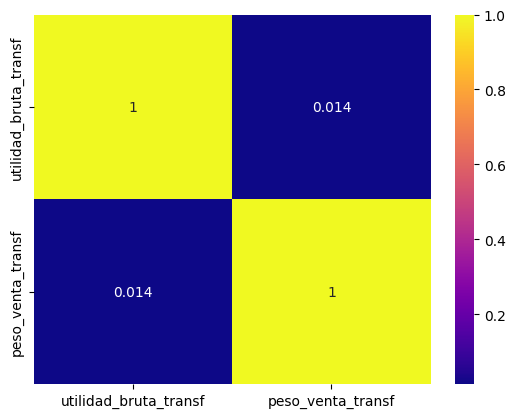

In [9]:
import seaborn as sb
data_2 = combined_data[['utilidad_bruta_transf','peso_venta_transf']]
sb.heatmap(data_2.corr(),annot=True, cmap="plasma")

In [10]:
data_m['customer_id'].value_counts()

customer_id
9522     2040
7667     1930
4490     1687
950      1671
10004    1657
         ... 
15297       1
7385        1
5037        1
1424        1
15300       1
Name: count, Length: 15312, dtype: int64

In [11]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006437 entries, 0 to 2006436
Data columns (total 12 columns):
 #   Column              Dtype   
---  ------              -----   
 0   fecha_compra        object  
 1   customer_id         category
 2   product_id          category
 3   type_id             category
 4   business_id         category
 5   channel_id          category
 6   cantidad_venta      float64 
 7   monto_venta_transf  float64 
 8   family_id           category
 9   negocio_id          category
 10  category_id         category
 11  tier_id             category
dtypes: category(9), float64(2), object(1)
memory usage: 69.6+ MB


In [12]:
pd.DataFrame([{'products': len(data_m['product_id'].value_counts()),
               'transactions': len(data_m['cantidad_venta'].value_counts()),
               'customers': len(data_m['customer_id'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,932,147,15312


In [13]:
data_m['fecha_compra'] = pd.to_datetime(data_m['fecha_compra'])

In [14]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006437 entries, 0 to 2006436
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   fecha_compra        datetime64[ns]
 1   customer_id         category      
 2   product_id          category      
 3   type_id             category      
 4   business_id         category      
 5   channel_id          category      
 6   cantidad_venta      float64       
 7   monto_venta_transf  float64       
 8   family_id           category      
 9   negocio_id          category      
 10  category_id         category      
 11  tier_id             category      
dtypes: category(9), datetime64[ns](1), float64(2)
memory usage: 69.6 MB


In [15]:
data_m.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,family_id,negocio_id,category_id,tier_id
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,1427,20,173,2
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,1427,20,173,2
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,1427,20,173,2
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,1427,20,173,2
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,1427,20,173,2


In [52]:
data_m['product_id'].unique()

[510, 512, 525, 591, 587, ..., 169, 835, 621, 275, 292]
Length: 932
Categories (932, int64): [1, 2, 3, 4, ..., 934, 935, 936, 937]

In [16]:
recency_df = data_m.groupby(['customer_id'],as_index=False)['fecha_compra'].max().copy()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,1,2023-01-28
1,2,2023-01-28
2,3,2023-01-21
3,4,2023-01-26
4,5,2023-02-04


In [17]:
now =data_m['fecha_compra'].max()
now

Timestamp('2023-02-04 00:00:00')

In [18]:
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)
recency_df.head()

,CustomerID,Recency
0,1,7
1,2,7
2,3,14
3,4,9
4,5,0


In [19]:
frequency_df = data_m.copy()
frequency_df.drop_duplicates(subset=['customer_id','cantidad_venta'], keep="first", inplace=True)
frequency_df = frequency_df.groupby('customer_id',as_index=False)['cantidad_venta'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,1,18
1,2,11
2,3,7
3,4,7
4,5,12


In [20]:
monetary_df=data_m.groupby('customer_id',as_index=False)['monto_venta_transf'].sum().copy()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,1,4215.025943
1,2,490.966092
2,3,635.393427
3,4,462.436700
4,5,1506.377974


In [21]:
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID').copy()

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID').copy()

rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
1,7,18,4215.025943
2,7,11,490.966092
3,14,7,635.393427
4,9,7,462.436700
5,0,12,1506.377974


In [22]:
rfm_analysis = rfm.copy()

In [23]:
rfm["recency_score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method= "first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
CustomerID,,,,,,
1,7,18,4215.025943,3,5,4
2,7,11,490.966092,3,4,2
3,14,7,635.393427,2,3,2
4,9,7,462.436700,3,3,2
5,0,12,1506.377974,5,5,3


In [24]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                        rfm['frequency_score'].astype(str))

In [25]:
rfm

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
1,7,18,4215.025943,3,5,4,35
2,7,11,490.966092,3,4,2,34
3,14,7,635.393427,2,3,2,23
4,9,7,462.436700,3,3,2,33
5,0,12,1506.377974,5,5,3,55
...,...,...,...,...,...,...,...
15308,5,2,74.735139,3,1,1,31
15309,10,1,38.849766,2,1,1,21
15310,1,5,1444.959447,5,2,3,52


In [26]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)

new_df = pd.DataFrame()

new_df["new_customer_id"] = rfm[rfm["segment"] == "new_customers"].index

new_df["new_customer_id"] = new_df["new_customer_id"].astype(int)

In [27]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
1,7,18,4215.025943,3,5,4,35,loyal_customers
2,7,11,490.966092,3,4,2,34,loyal_customers
3,14,7,635.393427,2,3,2,23,at_Risk
4,9,7,462.436700,3,3,2,33,need_attention
5,0,12,1506.377974,5,5,3,55,champions


In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\JOSE\anaconda3\

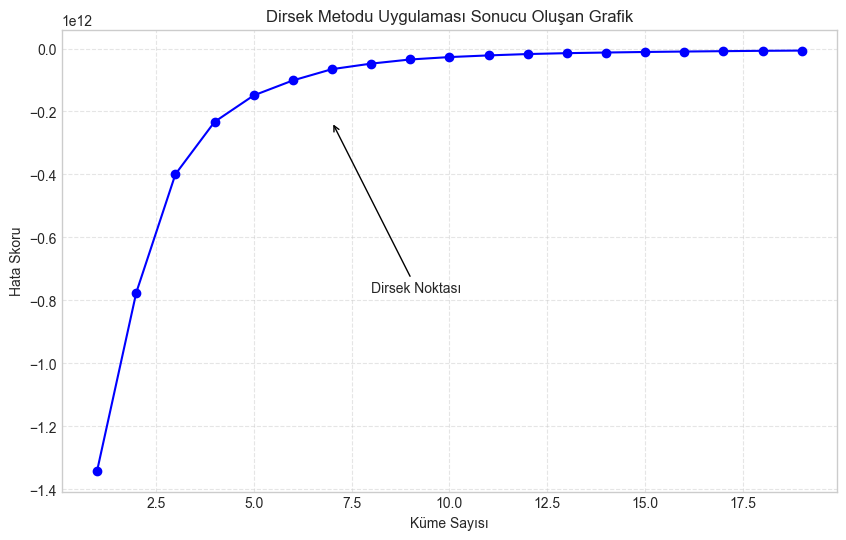

In [29]:
rfm_segmentation = rfm_analysis.copy()

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]

plt.figure(figsize=(10, 6))
plt.style.use('seaborn-whitegrid')

plt.plot(Nc, score, marker='o', linestyle='-', color='b')

plt.xlabel('Küme Sayısı')
plt.ylabel('Hata Skoru')
plt.title('Dirsek Metodu Uygulaması Sonucu Oluşan Grafik')

plt.grid(True, linestyle='--', alpha=0.5)

plt.annotate('Dirsek Noktası', xy=(7, score[3]), xytext=(8, score[1]),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.show()

In [30]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

rfm_segmentation['cluster'] = kmeans.labels_
rfm_segmentation[rfm_segmentation.cluster == 0].head(5)

c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary,cluster
CustomerID,,,,
1,7,18,4215.025943,0
2,7,11,490.966092,0
3,14,7,635.393427,0
4,9,7,462.436700,0
5,0,12,1506.377974,0


In [31]:
rfm_segmentation['cluster'].value_counts()

cluster
0    14754
1      557
2        1
Name: count, dtype: int64

c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.8862592139626654


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.8754486799077484


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.813300144012738


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.776630943914534


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.7602443900814448


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.722568047875563


c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.695003017022307


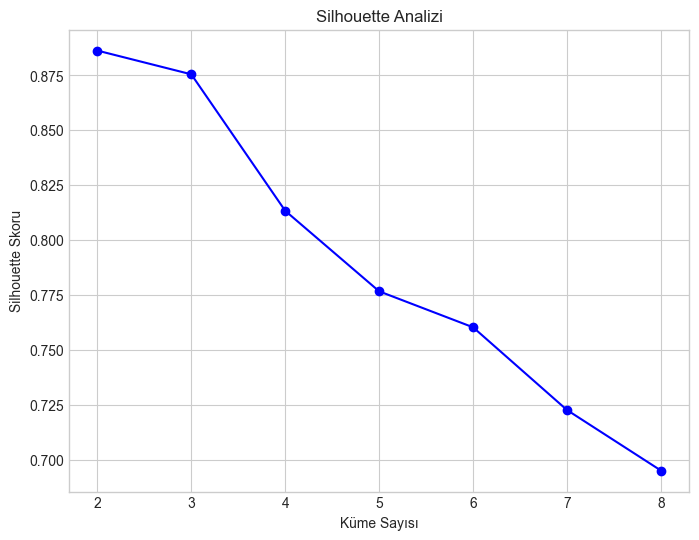

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_segmentation)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_segmentation, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='b')

plt.xlabel('Küme Sayısı')
plt.ylabel('Silhouette Skoru')
plt.title('Silhouette Analizi')


plt.show()

In [33]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(rfm_segmentation)

rfm_segmentation['cluster'] = kmeans.labels_
rfm_segmentation[rfm_segmentation.cluster == 0].head()

c:\Users\JOSE\anaconda3\envs\d2l\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary,cluster
CustomerID,,,,
2,7,11,490.966092,0
3,14,7,635.393427,0
4,9,7,462.436700,0
5,0,12,1506.377974,0
6,30,6,401.437935,0


In [34]:
rfm_segmentation['cluster'].value_counts()

cluster
0    11951
5     2388
1      720
6      215
3       35
4        2
2        1
Name: count, dtype: int64

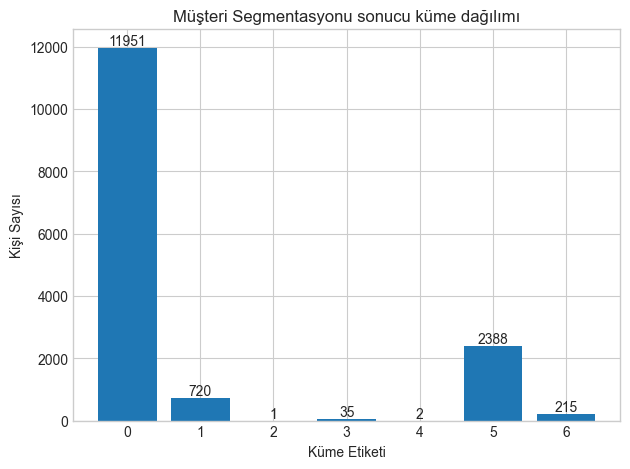

In [35]:
import matplotlib.pyplot as plt

cluster_labels = rfm_segmentation['cluster']

cluster_counts = cluster_labels.value_counts().sort_index()


plt.bar(cluster_counts.index, cluster_counts.values)

for i, count in enumerate(cluster_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Küme Etiketi')
plt.ylabel('Kişi Sayısı')
plt.title('Müşteri Segmentasyonu sonucu küme dağılımı')

plt.xticks(cluster_counts.index)
plt.tight_layout()

plt.show()

In [36]:
rfm_segmentation.tail()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
15308,5,2,74.735139,0
15309,10,1,38.849766,0
15310,1,5,1444.959447,0
15311,15,2,8.794753,0
15312,0,2,344.335726,0


In [37]:
rfm_segmentation.columns

Index(['Recency', 'Frequency', 'Monetary', 'cluster'], dtype='object')

In [38]:
merged_df = pd.merge(data_m, rfm_segmentation, left_on='customer_id', right_index=True, how='left').copy()

In [39]:
merged_df.head()

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,family_id,negocio_id,category_id,tier_id,Recency,Frequency,Monetary,cluster
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,1427,20,173,2,1,10,996.785996,0
1,2022-01-31,9382,510,BO,21,V,1.0,0.153431,1427,20,173,2,1,15,3533.832057,0
2,2022-01-31,10355,510,BO,21,V,1.0,0.153431,1427,20,173,2,47,5,105.467562,0
3,2022-01-31,10394,510,BO,21,V,12.0,1.771688,1427,20,173,2,59,10,655.788107,0
4,2022-01-31,304,510,BO,21,V,12.0,1.829587,1427,20,173,2,4,11,2482.349527,0


In [40]:
merged_df.drop(["Frequency","Recency","Monetary"], axis = 1, inplace = True)

In [41]:
invoiceIDs = merged_df['cantidad_venta'].unique()
customer_vectors = {}

for i in invoiceIDs:
    grouped_df = merged_df[merged_df['cantidad_venta'] == i][['customer_id', 'product_id', 'cluster']]
    grouped_df = grouped_df.groupby('customer_id')[['product_id', 'cluster']].agg(list).reset_index()
    
    for _, row in grouped_df.iterrows():
        customer_id = row['customer_id']
        product_ids = row['product_id']
        clusters = row['cluster']
        
        if customer_id not in customer_vectors:
            customer_vectors[customer_id] = {'product_id': [], 'cluster': []}
        
        customer_vectors[customer_id]['product_id'].extend(product_ids)
        customer_vectors[customer_id]['cluster'].extend(clusters)

In [42]:
index = 0
customer_mapping = {}
reverse_customer_mapping = {}

for customer_id in merged_df['customer_id'].unique():
    customer_vectors[customer_id] = [merged_df[merged_df['customer_id'] == customer_id]['product_id'],merged_df[merged_df['customer_id'] == customer_id]['cluster']]
    customer_mapping[customer_id] = index
    reverse_customer_mapping = {index: customer_id for customer_id, index in customer_mapping.items()}
    index += 1 

In [43]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

index = 0
customer_mapping = {}
reverse_customer_mapping = {}
customer_vectors = {}

for customer_id in merged_df['customer_id'].unique():
    customer_vectors[customer_id] = [merged_df[merged_df['customer_id'] == customer_id]['product_id'],
        merged_df[merged_df['customer_id'] == customer_id]['cluster']]
    customer_mapping[customer_id] = index
    reverse_customer_mapping[index] = customer_id
    index += 1

def user_item_collaborative_filtering(user_id, top_n=5):
    max_length = max(len(customer_vectors[i][0]) for i in range(len(customer_vectors)))
    user_vector = np.array(
        list(customer_vectors[user_id][0]) + [0] * (max_length - len(customer_vectors[user_id][0]))
    ).reshape(1, -1)
    stacked_vectors = []
    for i in range(len(customer_vectors)):
        vector = customer_vectors[i][0].tolist()
        padded_vector = vector + [0] * (max_length - len(vector))
        stacked_vectors.append(padded_vector)
    similarities = cosine_similarity(user_vector, np.vstack(stacked_vectors))
    similar_indices = similarities.argsort()[0][::-1][1:top_n+1]
    recommended_products = []
    for index in similar_indices:
        similar_user_id = reverse_customer_mapping[index]
        recommended_products.extend(customer_vectors[similar_user_id][0])
    unique_recommended_products = list(set(recommended_products))

    return unique_recommended_products[:top_n]

In [44]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

index = 0
customer_mapping = {}
reverse_customer_mapping = {}
customer_vectors = {}

for customer_id in merged_df['customer_id'].unique():
    customer_vectors[customer_id] = [merged_df[merged_df['customer_id'] == customer_id]['product_id'],
        merged_df[merged_df['customer_id'] == customer_id]['cluster']]
    customer_mapping[customer_id] = index
    reverse_customer_mapping[index] = customer_id
    index += 1

def user_item_collaborative_filtering(user_id, top_n=5):
    max_length = max(len(customer_vectors[i][0]) for i in range(len(customer_vectors)))
    user_vector = np.array(
        list(customer_vectors[user_id][0]) + [0] * (max_length - len(customer_vectors[user_id][0]))
    ).reshape(1, -1)
    stacked_vectors = []
    for i in range(len(customer_vectors)):
        vector = customer_vectors[i][0].tolist()
        padded_vector = vector + [0] * (max_length - len(vector))
        stacked_vectors.append(padded_vector)
    similarities = cosine_similarity(user_vector, np.vstack(stacked_vectors))
    similar_indices = similarities.argsort()[0][::-1][1:top_n+1]
    recommended_products = []
    for index in similar_indices:
        similar_user_id = reverse_customer_mapping[index]
        user_products = customer_vectors[similar_user_id][0]

        for product_id in user_products:
            if product_id not in recommended_products:
                recommended_products.append(product_id)
        if len(recommended_products) >= top_n:
            break
    return recommended_products[:top_n]

In [45]:
recommender_products_to_users = {}
for i in merged_df['customer_id'].unique():
    recommender_products_to_users[i] = user_item_collaborative_filtering(i,5)

KeyError: 0

In [46]:
data = {'customer_id': [], 'RecommendedProducts': []}


for customer_id, recommended_products in recommender_products_to_users.items():
    data['customer_id'].append(customer_id)
    data['RecommendedProducts'].append(recommended_products)

recommender_products_to_users_df = pd.DataFrame(data)

In [47]:
import pandas as pd

customer_products_df = pd.DataFrame(columns=['customer_id', 'product_id'])

customer_ids = merged_df['customer_id'].unique()

for customer_id in customer_ids:
    products = merged_df.loc[merged_df['customer_id'] == customer_id, 'product_id']
    customer_products_df = customer_products_df._append({'customer_id': customer_id, 'product_id': products.values}, ignore_index=True)

In [48]:
customer_products_df.head()

,customer_id,product_id
0,7157,"[510, 510, 510, 510, 510, ..., 99, 766, 766, 1..."
1,9382,"[510, 510, 512, 525, 525, ..., 296, 291, 342, ..."
2,10355,"[510, 510, 510, 510, 510, ..., 432, 393, 471, ..."
3,10394,"[510, 510, 510, 510, 510, ..., 532, 534, 534, ..."
4,304,"[510, 249, 249, 452, 452, ..., 283, 283, 276, ..."


In [51]:
customer_products_df['product_id'][0][:50]

[510, 510, 510, 510, 510, ..., 406, 409, 456, 456, 456]
Length: 50
Categories (932, int64): [1, 2, 3, 4, ..., 934, 935, 936, 937]

In [54]:
customer_id_to_find = 1
product_ids_for_customer_id_1 = customer_products_df.loc[customer_products_df['customer_id'] == customer_id_to_find, 'product_id'].iloc[0]

In [58]:
first_50_product_ids = []
seen_product_ids = set()

for product_id in product_ids_for_customer_id_1:
    if product_id not in seen_product_ids:
        first_50_product_ids.append(product_id)
        seen_product_ids.add(product_id)
    
    if len(first_50_product_ids) == 50:
        break
print(first_50_product_ids)

[510, 587, 452, 513, 354, 860, 388, 770, 616, 414, 861, 470, 496, 520, 514, 562, 563, 119, 8, 404, 453, 406, 456, 405, 809, 418, 459, 417, 315, 317, 318, 771, 375, 316, 333, 334, 425, 321, 322, 426, 21, 428, 774, 450, 659, 607, 569, 570, 101, 568]


In [59]:
customer_id_to_find = 2
product_ids_for_customer_id_1 = customer_products_df.loc[customer_products_df['customer_id'] == customer_id_to_find, 'product_id'].iloc[0]
first_50_product_ids = []
seen_product_ids = set()

for product_id in product_ids_for_customer_id_1:
    if product_id not in seen_product_ids:
        first_50_product_ids.append(product_id)
        seen_product_ids.add(product_id)
    
    if len(first_50_product_ids) == 50:
        break
print(first_50_product_ids)

[512, 587, 586, 467, 445, 452, 443, 414, 861, 738, 496, 119, 130, 404, 453, 406, 456, 405, 459, 741, 315, 425, 21, 427, 372, 930, 926, 190, 635, 890, 116, 67, 312, 120, 916, 66, 95, 195, 27, 911, 790, 88, 337, 745, 183, 99, 295, 531, 293, 343]


In [72]:
def get_first_50_product_ids(customer_products_df, customer_id_to_find):
    product_ids_for_customer = customer_products_df.loc[customer_products_df['customer_id'] == customer_id_to_find, 'product_id'].iloc[0]
    
    first_50_product_ids = []
    seen_product_ids = set()
    
    for product_id in product_ids_for_customer:
        if product_id not in seen_product_ids:
            first_50_product_ids.append(product_id)
            seen_product_ids.add(product_id)
        
        if len(first_50_product_ids) == 30:
            break
            
    return first_50_product_ids

In [73]:
output_data = []

for customer_id in customer_products_df['customer_id']:
    first_50_product_ids = get_first_50_product_ids(customer_products_df, customer_id)
    product_ids_string = ' '.join(map(str, first_50_product_ids))
    output_data.append({'customer_id': customer_id, 'product_id': product_ids_string})

output_df = pd.DataFrame(output_data)

output_csv_filename = 'submission2.csv'
output_df.to_csv(output_csv_filename, index=False, sep=',')

print("Data saved to:", output_csv_filename)

Data saved to: submission2.csv


In [74]:
len(output_data)

15312

In [49]:
recommender_products_to_users_df.head()

,customer_id,RecommendedProducts
